# 9. Evaluation of Higher Order Explanations

This notebook, part of the analysis phase of the project, is devoted to evaluating the generated higher order explanations using the proposed metrics.

In [ ]:
# Necessary imports
import ast
import pickle as pkl
import polars as pl
import sys
import numpy as np

import torch

import networkx as nx

import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch

import seaborn as sns

import sklearn

from pathlib import Path

from tqdm.auto import tqdm as tqdma

from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
)

# Get the absolute path of the project's root directory
ROOT_DIR = Path.resolve(Path.cwd() / "../")

# Add root directory to sys.path
sys.path.append(str(ROOT_DIR))

from src.utils.set_seed import set_seed
from src.utils.expl_utils import (
    predict_sample,
    nx_to_wrapped_tree,
    equalize_depths,
    wrapped_tree_to_nx,
    get_tree_height,
    populate_nodes_with_data,
    get_attributions_by_level,
    compute_comprehensiveness_higher_order,
    compute_sufficiency_higher_order,
    correct_faithfulness,
)

# Set the seed for reproducibility
rng = set_seed()

from sklearnex import patch_sklearn

patch_sklearn()


mpl.rcParams["text.usetex"] = True
mpl.rcParams["font.family"] = "serif"
mpl.rcParams["text.latex.preamble"] = r"\usepackage{mathpazo}"


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
2025-05-07 10:11:02.109664: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-07 10:11:02.117845: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-07 10:11:02.127488: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-07 10:11:02.130743: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has al

In [ ]:
# Directory management
DATA_DIR = ROOT_DIR / "data"
SPLITTED_DATA_DIR = DATA_DIR / "splitted"

MODELS_DIR = ROOT_DIR / "models"

OUTPUT_DIR = ROOT_DIR / "output"
IG_DIR = OUTPUT_DIR / "integrated_gradients"
TREES_DIR = OUTPUT_DIR / "constituency_trees"
IDG_DIR = OUTPUT_DIR / "integrated_directional_gradients"
SHAP_DIR = OUTPUT_DIR / "shap"
LIME_DIR = OUTPUT_DIR / "lime"

EVALUATION_DIR = OUTPUT_DIR / "evaluation"

FIGURES_DIR = ROOT_DIR / "etc/figures"


In [3]:
# Load the dataset
df_test_trees = pl.read_parquet(TREES_DIR / "test_2_classes_with_trees.parquet")


In [4]:
# Load the fine-tuned model and tokenizer
model_clf = AutoModelForSequenceClassification.from_pretrained(
    MODELS_DIR / "bert-base-uncased_2_classes",
)

tokenizer = AutoTokenizer.from_pretrained(
    MODELS_DIR / "bert-base-uncased_2_classes",
)


In [5]:
# Label encoding
label2id = {"normal": 0, "hatespeech": 1}
id2label = {id_: label for label, id_ in label2id.items()}
target_labels = list(label2id.keys())


***

## 9.1. Tree Postprocessing

Here, we balance the hierarchical attribution trees to be able to compute evaluation metrics

In [6]:
guids = df_test_trees["post_id"].to_list()


In [7]:
# Process the trees to balance them
for guid in tqdma(guids):
    try:
        # Load the tree
        dot_tree = nx.nx_agraph.read_dot(
            IDG_DIR / f"{guid}_idg_expl_image.dot",
        )
    except FileNotFoundError:
        print(f"File not found for guid: {guid}")
        continue

    # Construct wrapped tree
    ROOT_ = "a_n_0"
    wrapped_tree = nx_to_wrapped_tree(dot_tree, ROOT_)

    # Balance the tree
    balanced_tree, _ = equalize_depths(wrapped_tree)

    # Get the tree height
    height = get_tree_height(balanced_tree)

    # Convert to NetworkX graph
    balanced_tree_nx = wrapped_tree_to_nx(balanced_tree)

    # Populate the nodes with data
    tokens = df_test_trees.filter(pl.col("post_id") == guid)["tokens"].to_list()[0]
    try:
        populate_nodes_with_data(balanced_tree_nx, tokens)
    except Exception as _:
        print(f"Error populating nodes with data for guid {guid}. Skipping...")
        continue

    # Save the balanced tree
    nx.nx_agraph.write_dot(balanced_tree_nx, IDG_DIR / f"balanced/{guid}_idg_expl_image_balanced.dot")



  0%|          | 0/1376 [00:00<?, ?it/s]

File not found for guid: 10040607_gab
File not found for guid: 14445063_gab
File not found for guid: 1178921633031114752_twitter
File not found for guid: 1179048983420899328_twitter
File not found for guid: 1179098097160470529_twitter
File not found for guid: 1178785944238841857_twitter
File not found for guid: 12733084_gab
File not found for guid: 1178750958718914561_twitter
File not found for guid: 10362793_gab
File not found for guid: 10756657_gab
Error populating nodes with data for guid 1079100239183675392_twitter. Skipping...
File not found for guid: 1109087701960146945_twitter
File not found for guid: 1163082929557450753_twitter
File not found for guid: 1171521116570959872_twitter
File not found for guid: 1258666596333170689_twitter
Error populating nodes with data for guid 14971439_gab. Skipping...
File not found for guid: 21340695_gab


In [8]:
# Get the maximum height of the trees
max_level = 1

for guid in tqdma(guids):
    try:
        # Load the tree
        dot_tree = nx.nx_agraph.read_dot(
            IDG_DIR / f"balanced/{guid}_idg_expl_image_balanced.dot",
        )
    except FileNotFoundError:
        print(f"File not found for guid: {guid}")
        continue

    # Read the tokens
    max_level_ = max(
        [int(data["level"]) for _, data in dot_tree.nodes(data=True)],
    )

    max_level = max(max_level, max_level_)

print(f"Max level: {max_level}")

MAX_LEVEL = max_level




  0%|          | 0/1376 [00:00<?, ?it/s]

File not found for guid: 10040607_gab
File not found for guid: 14445063_gab
File not found for guid: 1178921633031114752_twitter
File not found for guid: 1179048983420899328_twitter
File not found for guid: 1179098097160470529_twitter
File not found for guid: 1178785944238841857_twitter
File not found for guid: 12733084_gab
File not found for guid: 1178750958718914561_twitter
File not found for guid: 10362793_gab
File not found for guid: 10756657_gab
File not found for guid: 1079100239183675392_twitter
File not found for guid: 1109087701960146945_twitter
File not found for guid: 1163082929557450753_twitter
File not found for guid: 1171521116570959872_twitter
File not found for guid: 1258666596333170689_twitter
File not found for guid: 14971439_gab
File not found for guid: 21340695_gab
Max level: 31


***

## 9.2. Faithfulness Metrics

In [10]:
thresholds_idg = np.array([])

comprehensivenesses_idg = {
    lvl: np.array([]) for lvl in range(1, MAX_LEVEL + 1)
}
sufficiencies_idg = {
    lvl: np.array([]) for lvl in range(1, MAX_LEVEL + 1)
}

with tqdma(total=len(guids)) as pbar:
    for guid in guids:
        pbar.set_description(f"GUID: {guid}")
        try:
            # Load the tree
            dot_tree = nx.nx_agraph.read_dot(
                IDG_DIR / f"balanced/{guid}_idg_expl_image_balanced.dot",
            )
        except FileNotFoundError:
            print(f"File not found for guid: {guid}")
            continue

        # Read the tokens
        tokens = df_test_trees.filter(pl.col("post_id") == guid)["tokens"].to_list()[0]

        # Get the attributions by level
        attributions_by_level = get_attributions_by_level(dot_tree, tokens)

        # Predict the class
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model_clf.to(device)
        model_clf.eval()

        probabilities = predict_sample(
            model_clf,
            tokenizer,
            tokens,
            device=device,
            model_to_gpu_mode=False,
        )
        predicted_class = probabilities.argmax()

        thresholds_ = np.linspace(0, 1, 100)

        for lvl in attributions_by_level:
            # Get the attributions for the current level
            attributions = attributions_by_level[lvl]

            comprehensivenesses_ = np.array([])
            sufficiencies_ = np.array([])

            # Compute the comprehensiveness and sufficiency for each threshold
            for threshold in thresholds_:
                comprehensiveness = compute_comprehensiveness_higher_order(
                    model_clf,
                    tokenizer,
                    tokens,
                    attributions,
                    threshold,
                    device,
                    original_probabilities=probabilities,
                    predicted_class=predicted_class,
                )

                sufficiency = compute_sufficiency_higher_order(
                    model_clf,
                    tokenizer,
                    tokens,
                    attributions,
                    threshold,
                    device,
                    original_probabilities=probabilities,
                    predicted_class=predicted_class,
                )

                comprehensivenesses_ = np.append(
                    comprehensivenesses_,
                    comprehensiveness,
                )
                sufficiencies_ = np.append(
                    sufficiencies_,
                    sufficiency,
                )

            thresholds_idg = np.vstack(
                (thresholds_idg, thresholds_),
            ) if thresholds_idg.size else thresholds_
            comprehensivenesses_idg[lvl] = np.vstack(
                (comprehensivenesses_idg[lvl], comprehensivenesses_),
            ) if comprehensivenesses_idg[lvl].size else comprehensivenesses_
            sufficiencies_idg[lvl] = np.vstack(
                (sufficiencies_idg[lvl], sufficiencies_),
            ) if sufficiencies_idg[lvl].size else sufficiencies_
        pbar.update(1)




  0%|          | 0/1376 [00:00<?, ?it/s]

File not found for guid: 10040607_gab
File not found for guid: 14445063_gab
File not found for guid: 1178921633031114752_twitter
File not found for guid: 1179048983420899328_twitter
File not found for guid: 1179098097160470529_twitter
File not found for guid: 1178785944238841857_twitter
File not found for guid: 12733084_gab
File not found for guid: 1178750958718914561_twitter
File not found for guid: 10362793_gab
File not found for guid: 10756657_gab
File not found for guid: 1079100239183675392_twitter
File not found for guid: 1109087701960146945_twitter
File not found for guid: 1163082929557450753_twitter
File not found for guid: 1171521116570959872_twitter
File not found for guid: 1258666596333170689_twitter
File not found for guid: 14971439_gab
File not found for guid: 21340695_gab


In [11]:
# Save the results
with Path.open(EVALUATION_DIR / "faithfulness_higher_order_idg.pkl", "wb") as f:
    pkl.dump(
        {
            "thresholds_idg": thresholds_idg,
            "comprehensivenesses_idg": comprehensivenesses_idg,
            "sufficiencies_idg": sufficiencies_idg,
        },
        f,
    )


## 9.3. Results

In [9]:
with Path.open(EVALUATION_DIR / "faithfulness_higher_order_idg.pkl", "rb") as f:
    faithfulness_idg = pkl.load(f)

thresholds_idg = faithfulness_idg["thresholds_idg"]
comprehensiveness_idg = faithfulness_idg["comprehensivenesses_idg"]
sufficiencies_idg = faithfulness_idg["sufficiencies_idg"]


In [ ]:
# Compute the support for each level (number of trees that have a node at that level)
def compute_support(
    faithfulness_by_level: dict,
    max_level: int,
) -> dict:
    """Compute the support for each level (number of trees that have a node at that level).

    Args:
        faithfulness_by_level (dict): Dictionary with the faithfulness values for each level.
        max_level (int): Maximum level of the trees.

    Returns:
        dict: Dictionary with the support for each level.

    """
    support = dict.fromkeys(range(1, max_level + 1), 0)

    for lvl, faithfulness in faithfulness_by_level.items():
        if not faithfulness.size:
            continue
        support[lvl] = len(faithfulness) if len(faithfulness.shape) > 1 else 1

    return support


support_comprehensiveness_idg = compute_support(
    comprehensiveness_idg,
    max_level=MAX_LEVEL,
)


# Compute the mean maximum span coverage at each level
span_coverages_idg = dict.fromkeys(range(1, MAX_LEVEL + 1), np.zeros(1))

for guid in tqdma(guids):
    try:
        # Load the tree
        dot_tree = nx.nx_agraph.read_dot(
            IDG_DIR / f"balanced/{guid}_idg_expl_image_balanced.dot",
        )
    except FileNotFoundError:
        print(f"File not found for guid: {guid}")
        continue

    # Read the tokens
    tokens = df_test_trees.filter(pl.col("post_id") == guid)["tokens"].to_list()[0]

    # Get the attributions by level
    attributions_by_level = get_attributions_by_level(dot_tree, tokens)

    for level, attributions in attributions_by_level.items():
        coverage_at_level = np.array([])

        for token_idxs in attributions:
            token_idxs_ = ast.literal_eval(token_idxs)

            coverage = len(token_idxs_) / len(tokens)
            coverage_at_level = np.append(
                coverage_at_level,
                coverage,
            )

        max_coverage_at_level = np.max(coverage_at_level) if coverage_at_level.size else 0
        span_coverages_idg[level] = np.append(
            span_coverages_idg[level],
            max_coverage_at_level,
        )

for level, coverage in span_coverages_idg.items():
    if not coverage.size:
        continue
    span_coverages_idg[level] = np.array([coverage.mean(axis=0)])






  0%|          | 0/1376 [00:00<?, ?it/s]

File not found for guid: 10040607_gab
File not found for guid: 14445063_gab
File not found for guid: 1178921633031114752_twitter
File not found for guid: 1179048983420899328_twitter
File not found for guid: 1179098097160470529_twitter
File not found for guid: 1178785944238841857_twitter
File not found for guid: 12733084_gab
File not found for guid: 1178750958718914561_twitter
File not found for guid: 10362793_gab
File not found for guid: 10756657_gab
File not found for guid: 1079100239183675392_twitter
File not found for guid: 1109087701960146945_twitter
File not found for guid: 1163082929557450753_twitter
File not found for guid: 1171521116570959872_twitter
File not found for guid: 1258666596333170689_twitter
File not found for guid: 14971439_gab
File not found for guid: 21340695_gab


/tmp/ipykernel_8560/354959869.py:52: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


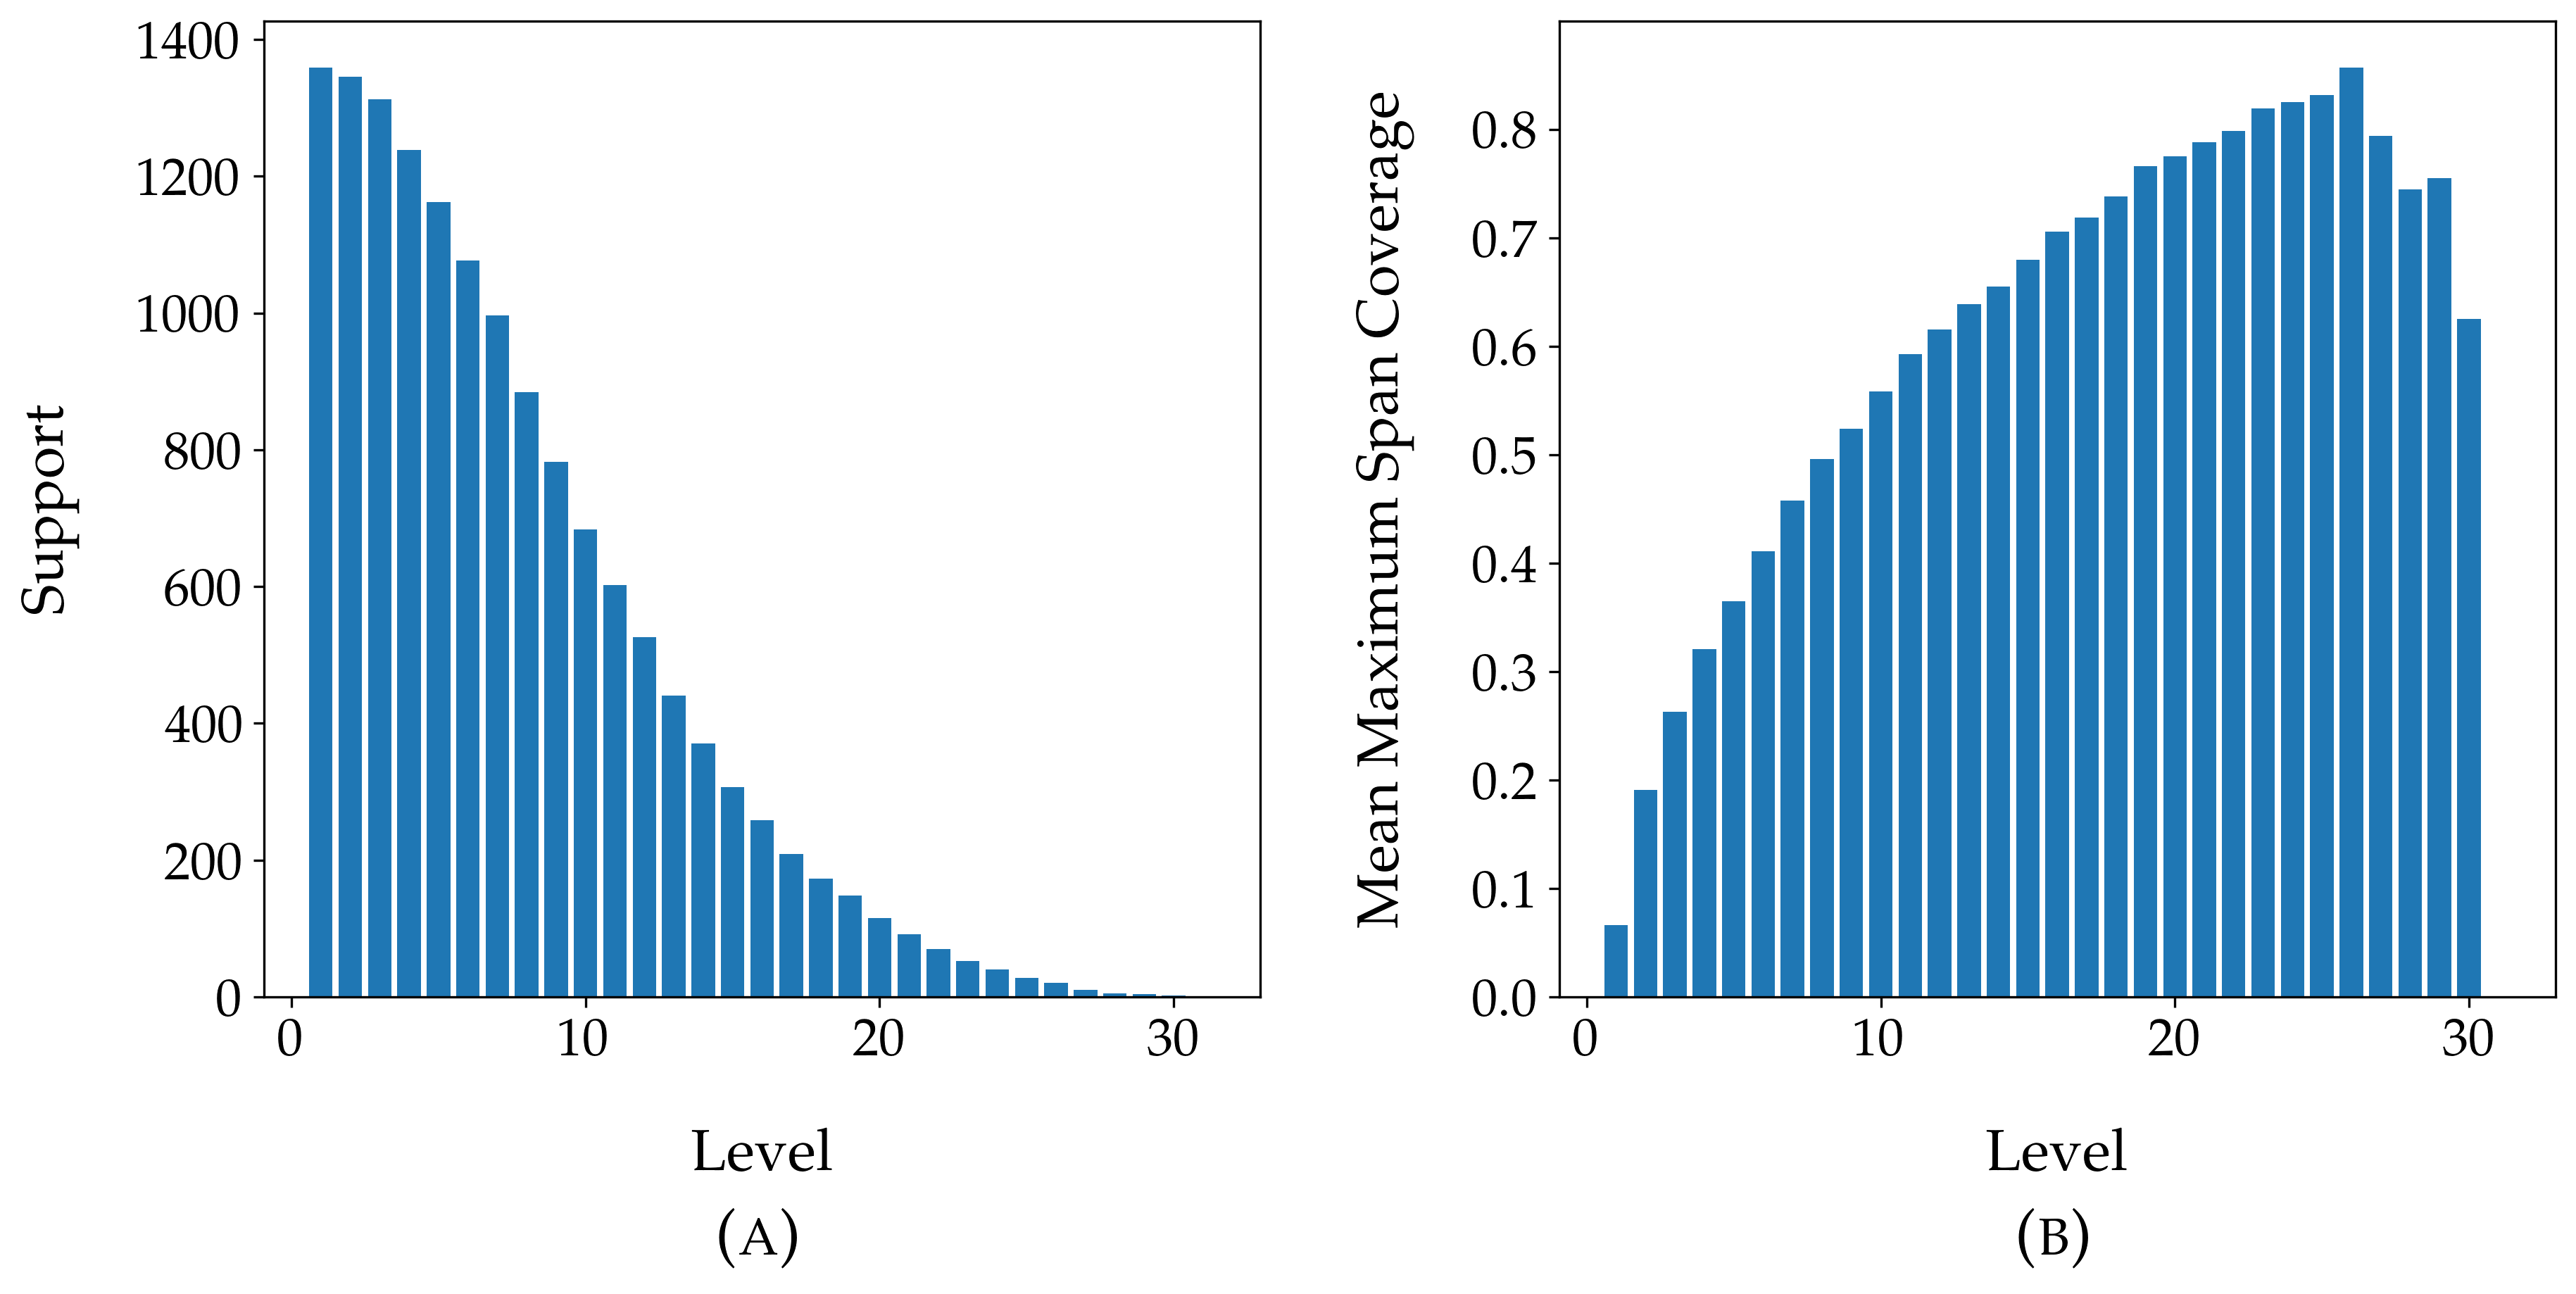

In [ ]:
fig, axs = plt.subplots(
    1, 2,
    figsize=(14, 6),
    dpi=300,
    sharex=True,
    gridspec_kw={"wspace": 0.3},
)


axs[0].bar(
    support_comprehensiveness_idg.keys(),
    support_comprehensiveness_idg.values(),
    color="tab:blue",
    label="Support",
)

# ax.legend(fontsize=18)

axs[0].tick_params(axis="both", which="major", labelsize=18)

axs[0].set_xlabel(r"Level", fontdict={"size": 20}, labelpad=20)
axs[0].set_ylabel(r"Support", fontdict={"size": 20}, labelpad=20)

# ax.set_xlim(0, 1)
# ax.set_ylim(0, 0.40)



axs[1].bar(
    span_coverages_idg.keys(),
     np.array(list(span_coverages_idg.values())).flatten(),
    color="tab:blue",
    label="Mean Maximum Span Coverage",
)

# ax.legend(fontsize=18)

axs[1].tick_params(axis="both", which="major", labelsize=18)

axs[1].set_xlabel(r"Level", fontdict={"size": 20}, labelpad=20)
axs[1].set_ylabel(r"Mean Maximum Span Coverage", fontdict={"size": 20}, labelpad=20)

# ax.set_xlim(0, 1)
# ax.set_ylim(0, 0.40)


axs[0].text(0.5, -.25, r"(\textsc{a})", transform=axs[0].transAxes,
            ha="center", va="center", fontsize=22)
axs[1].text(0.5, -.25, r"(\textsc{b})", transform=axs[1].transAxes,
            ha="center", va="center", fontsize=22)

plt.tight_layout()
plt.savefig(
    FIGURES_DIR / "expl_eval" / "eval_level_biases_comb.png",
    bbox_inches="tight",
)


***

In [ ]:
# Plot the comprehensiveness and sufficiency-threshold curves
for lvl, comprehensiveness in comprehensiveness_idg.items():
    if not comprehensiveness.size:
        continue
    if len(comprehensiveness.shape) > 1:
        comprehensiveness = np.mean(comprehensiveness, axis=0)

    comprehensiveness_idg[lvl] = comprehensiveness

for lvl, sufficiency in sufficiencies_idg.items():
    if not sufficiency.size:
        continue
    if len(sufficiency.shape) > 1:
        sufficiency = np.mean(sufficiency, axis=0)

    sufficiencies_idg[lvl] = sufficiency


# Correct the biases in the comprehensiveness and sufficiency curves
corrected_comprehensiveness_idg = correct_faithfulness(
    comprehensiveness_idg,
    support_by_level=support_comprehensiveness_idg,
    span_coverages_by_level=span_coverages_idg,
    max_level=MAX_LEVEL,
)

corrected_sufficiencies_idg = correct_faithfulness(
    sufficiencies_idg,
    support_by_level=support_comprehensiveness_idg,
    span_coverages_by_level=span_coverages_idg,
    max_level=MAX_LEVEL,
)

corrected_comprehensiveness_curve = np.sum(
    np.array(list(corrected_comprehensiveness_idg.values())),
    axis=0,
)

corrected_sufficiency_curve = np.sum(
    np.array(list(corrected_sufficiencies_idg.values())),
    axis=0,
)


# Compute AUCPC and AOSPC
aucpc = sklearn.metrics.auc(
    thresholds_idg[0],
    corrected_comprehensiveness_curve,
)
aospc = 1. - sklearn.metrics.auc(
    thresholds_idg[0],
    corrected_sufficiency_curve,
)
print(f"AUCPC: {aucpc}")
print(f"AOSPC: {aospc}")



/tmp/ipykernel_429968/4195537778.py:118: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


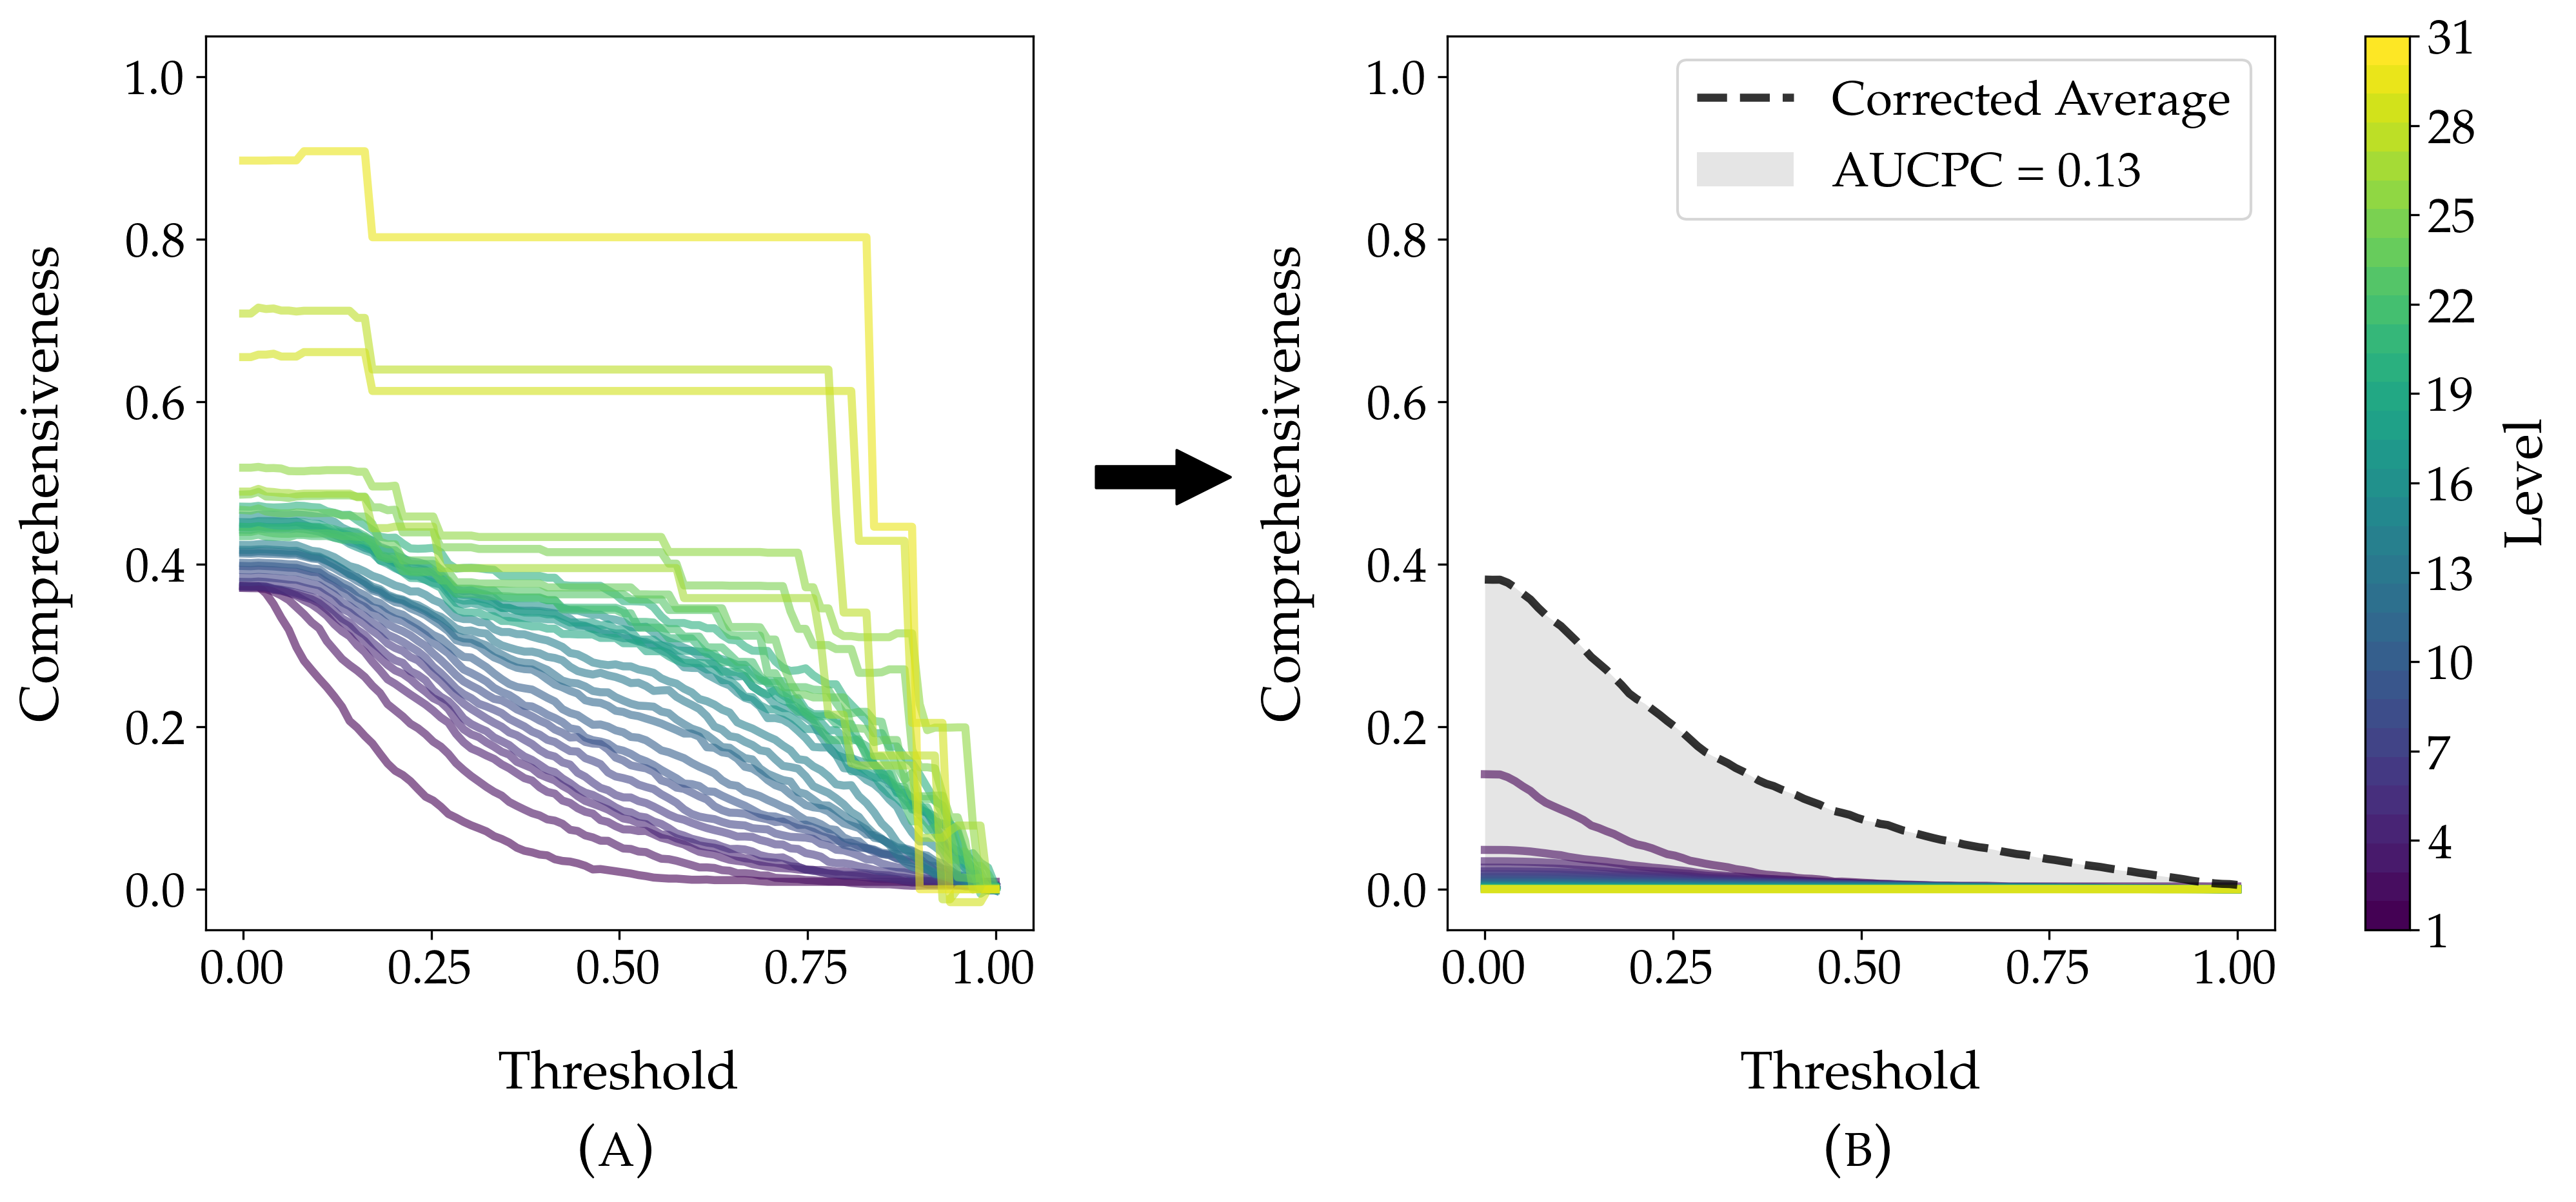

In [ ]:
fig, axs = plt.subplots(
    nrows=1,
    ncols=2,
    figsize=(15, 6),
    sharex=True,
    sharey=False,
    dpi=300,
    gridspec_kw={"wspace": 0.5},
)


cmap = plt.get_cmap("viridis", lut=max(support_comprehensiveness_idg.keys()))
norm = plt.Normalize(vmin=min(support_comprehensiveness_idg.keys()), vmax=max(support_comprehensiveness_idg.keys()))

# Create a ScalarMappable for the colorbar
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Needed for compatibility


for lvl in comprehensiveness_idg:
    if not comprehensiveness_idg[lvl].size:
        continue
    axs[0].plot(
        np.linspace(0, 1, 100),
        comprehensiveness_idg[lvl],
        label=f"Level {lvl}",
        color=cmap(norm(lvl)),
        alpha=0.6,
        lw=3,
    )

axs[0].tick_params(axis="both", which="major", labelsize=18)

axs[0].set_xlabel(r"Threshold", fontdict={"size": 20}, labelpad=20)
axs[0].set_ylabel(r"Comprehensiveness", fontdict={"size": 20}, labelpad=20)

axs[0].set_ylim(-0.05, 1.05)



for lvl in corrected_comprehensiveness_idg:
    if not corrected_comprehensiveness_idg[lvl].size:
        continue
    axs[1].plot(
        np.linspace(0, 1, 100),
        corrected_comprehensiveness_idg[lvl],
        color=cmap(norm(lvl)),
        alpha=0.6,
        lw=3,
    )

axs[1].plot(
    np.linspace(0, 1, 100),
    corrected_comprehensiveness_curve,
    label="Corrected Average",
    color="black",
    alpha=0.8,
    ls="--",
    lw=3,
)

axs[1].fill_between(
    np.linspace(0, 1, 100),
    corrected_comprehensiveness_curve,
    color="black",
    alpha=0.1,
    lw=0,
    zorder=-1,
    label=f"AUCPC = {aucpc:.2f}",
)


axs[1].legend(
    fontsize=18,
)

axs[1].tick_params(axis="both", which="major", labelsize=18)

axs[1].set_xlabel(r"Threshold", fontdict={"size": 20}, labelpad=20)
axs[1].set_ylabel(r"Comprehensiveness", fontdict={"size": 20}, labelpad=20)

axs[1].set_ylim(-0.05, 1.05)


arrow = FancyArrowPatch(
    (0.43, 0.5),  # start: middle right of left plot
    (0.48, 0.5),  # end: middle left of right plot
    transform=fig.transFigure,
    arrowstyle="simple",
    mutation_scale=40,
    color="black",
    linewidth=1,
)
fig.patches.append(arrow)


# Create colorbar to the right of the second axis
cb = fig.colorbar(
    sm,
    ax=axs,
    location="right",
    fraction=0.04,  # adjust this for size
    pad=0.04,       # adjust distance from plots
)
cb.set_label("Level", fontsize=20, labelpad=10)
cb.ax.tick_params(labelsize=18)
cb.ax.set_yticks(np.arange(1, max(support_comprehensiveness_idg.keys()) + 1, 3))


axs[0].text(0.5, -.25, r"(\textsc{a})", transform=axs[0].transAxes,
            ha="center", va="center", fontsize=22)
axs[1].text(0.5, -.25, r"(\textsc{b})", transform=axs[1].transAxes,
            ha="center", va="center", fontsize=22)

plt.tight_layout()
plt.savefig(
    FIGURES_DIR / "expl_eval" / "eval_comprehensiveness_ho.png",
    bbox_inches="tight",
)



/tmp/ipykernel_429968/1744080065.py:118: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


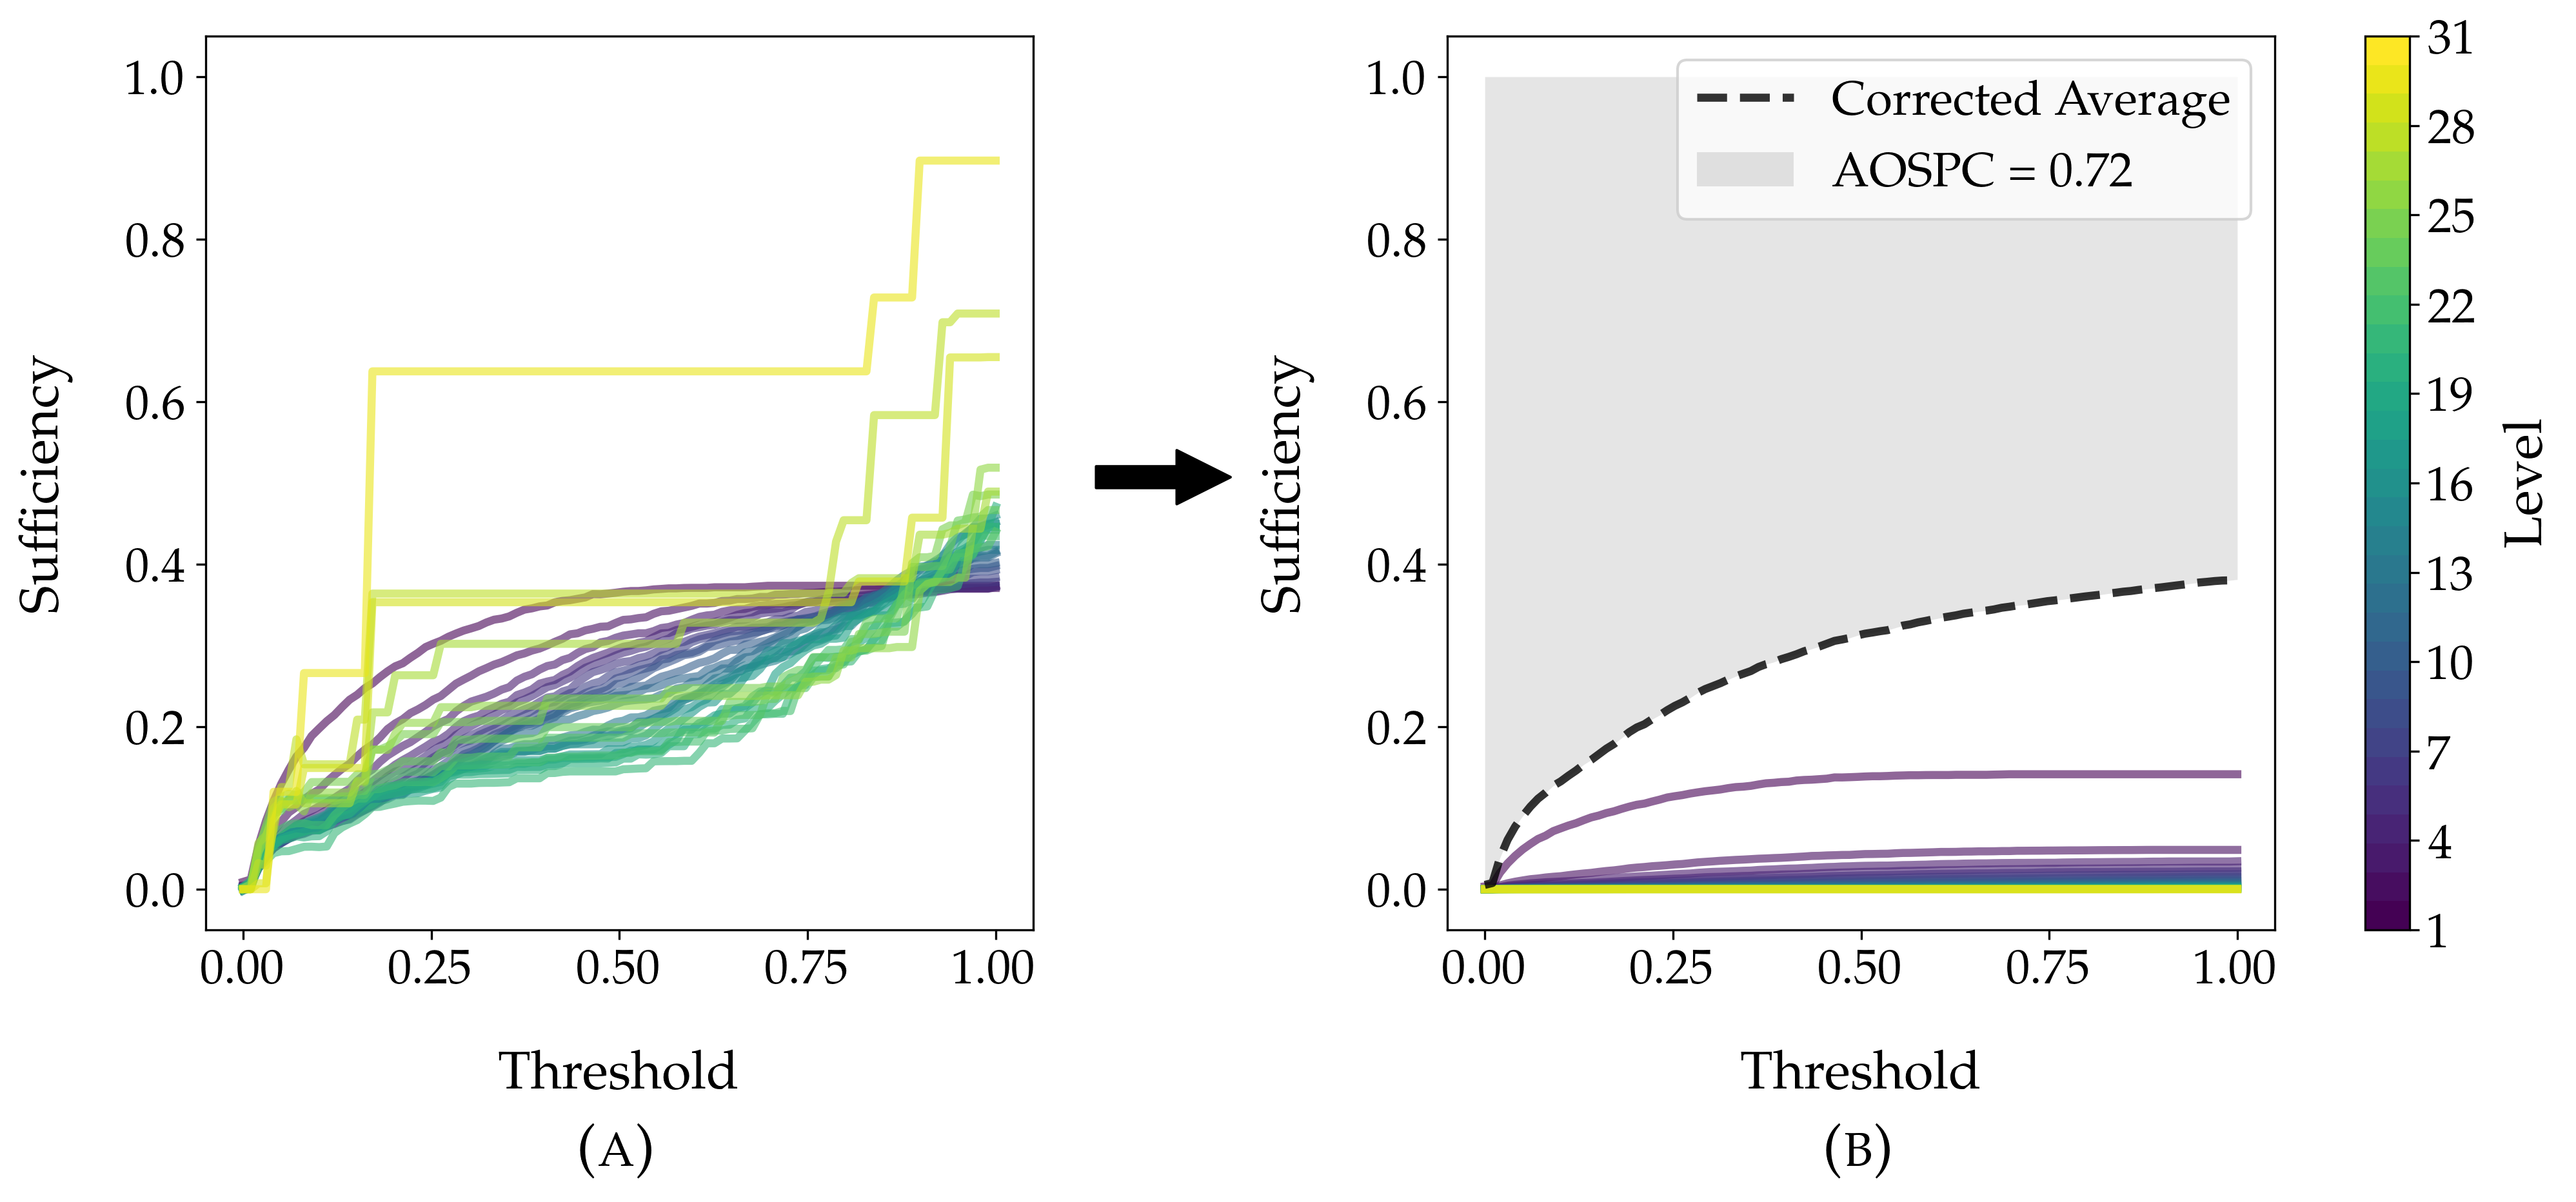

In [ ]:
fig, axs = plt.subplots(
    nrows=1,
    ncols=2,
    figsize=(15, 6),
    sharex=True,
    sharey=False,
    dpi=300,
    gridspec_kw={"wspace": 0.5}, 
)


cmap = plt.get_cmap("viridis", lut=max(support_comprehensiveness_idg.keys()))
norm = plt.Normalize(vmin=min(support_comprehensiveness_idg.keys()), vmax=max(support_comprehensiveness_idg.keys()))

# Create a ScalarMappable for the colorbar
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Needed for compatibility


for lvl in sufficiencies_idg:
    if not sufficiencies_idg[lvl].size:
        continue
    axs[0].plot(
        np.linspace(0, 1, 100),
        sufficiencies_idg[lvl],
        label=f"Level {lvl}",
        color=cmap(norm(lvl)),
        alpha=0.6,
        lw=3,
    )

axs[0].tick_params(axis="both", which="major", labelsize=18)

axs[0].set_xlabel(r"Threshold", fontdict={"size": 20}, labelpad=20)
axs[0].set_ylabel(r"Sufficiency", fontdict={"size": 20}, labelpad=20)

axs[0].set_ylim(-0.05, 1.05)



for lvl in corrected_sufficiencies_idg:
    if not corrected_sufficiencies_idg[lvl].size:
        continue
    axs[1].plot(
        np.linspace(0, 1, 100),
        corrected_sufficiencies_idg[lvl],
        color=cmap(norm(lvl)),
        alpha=0.6,
        lw=3,
    )

axs[1].plot(
    np.linspace(0, 1, 100),
    corrected_sufficiency_curve,
    label="Corrected Average",
    color="black",
    alpha=0.8,
    ls="--",
    lw=3,
)

axs[1].fill_between(
    np.linspace(0, 1, 100),
    corrected_sufficiency_curve,
    1,
    color="black",
    alpha=0.1,
    lw=0,
    zorder=-1,
    label=f"AOSPC = {aospc:.2f}",
)

axs[1].legend(
    fontsize=18,
    loc="upper right",
)

axs[1].tick_params(axis="both", which="major", labelsize=18)

axs[1].set_xlabel(r"Threshold", fontdict={"size": 20}, labelpad=20)
axs[1].set_ylabel(r"Sufficiency", fontdict={"size": 20}, labelpad=20)

axs[1].set_ylim(-0.05, 1.05)


arrow = FancyArrowPatch(
    (0.43, 0.5),
    (0.48, 0.5),
    transform=fig.transFigure,
    arrowstyle="simple",
    mutation_scale=40,
    color="black",
    linewidth=1,
)
fig.patches.append(arrow)


# Create colorbar to the right of the second axis
cb = fig.colorbar(
    sm,
    ax=axs,
    location="right",
    fraction=0.04,
    pad=0.04,
)
cb.set_label("Level", fontsize=20, labelpad=10)
cb.ax.tick_params(labelsize=18)
cb.ax.set_yticks(np.arange(1, max(support_comprehensiveness_idg.keys()) + 1, 3))

axs[0].text(0.5, -.25, r"(\textsc{a})", transform=axs[0].transAxes,
            ha="center", va="center", fontsize=22)
axs[1].text(0.5, -.25, r"(\textsc{b})", transform=axs[1].transAxes,
            ha="center", va="center", fontsize=22)

plt.tight_layout()
plt.savefig(
    FIGURES_DIR / "expl_eval" / "eval_sufficiency_ho.png",
    bbox_inches="tight",
)
